# Lecture 3 -- Counting Words

Using the counts of words in a document is a good starting point for descriptive analysis, visualization, and predictive modeling. For example, counts of words is what makes up the data behind [Google Search Trends](https://trends.google.com/home) and the [Google NGram Viewer](https://books.google.com/ngrams/).

Between search trends, ngram viewer, and more, the goal is to provide a broad picture as to what things are being discussed, searched, mentioned, etc.

Applying this same idea to municipal legislative data, we might try understand what general topics are commonly discussed in a council via core words for a topic. For example, if the words "housing", "rent", and "affordability" are all spoken frequently in a city council meeting, we can broadly interpret that those three terms (and more general ideas about "housing affordability") were important topics of the meeting.

So for this chapter, let's try to be able to **find and compare common topics discussed in a city council meeting, via word counts.**

## Let's Count

Counting words is such a common task and is so heavily utilized that `scikit-learn` has a whole class for doing just that called [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

# Create CountVectorizer object
count_vec = CountVectorizer()

# An example sentence we will count the words in
example = "Hello my name is Eva and I am commenting today in opposition of this bill."

# Get counts
counts = count_vec.fit_transform([example])
counts

<1x14 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

Don't be afraid of the "sparse matrix" it is just an efficient storage mechanism that scikit-learn uses. We can see the results in a pandas dataframe too by doing the following.

In [2]:
import pandas as pd

counts_df = pd.DataFrame(
    counts.toarray(),  # convert from sparse matrix to numpy
    columns=count_vec.get_feature_names_out(),  # store words as the column names
)
counts_df

,am,and,bill,commenting,eva,hello,in,is,my,name,of,opposition,this,today
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Let's take a moment to notice that all of the words have been lowercased.

There are many decisions to make when counting and we recommend you view the documentation for [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to see all of the options but we will highlight a few throughout the rest of this chapter.

First, as already noted, lowercasing is something you can enable or disable. It depends on how specific you want your counts to be, do you want "House" and "house" to be counted separately? The only difference between the two might be that one is the first word in a sentence, but there are many other cases where casing is important to keep.

In [3]:
# And example of turning off lowercasing
count_vec_no_lowercase = CountVectorizer(lowercase=False)
pd.DataFrame(
    count_vec_no_lowercase.fit_transform([example]).toarray(),
    columns=count_vec_no_lowercase.get_feature_names_out(),
)

,Eva,Hello,am,and,bill,commenting,in,is,my,name,of,opposition,this,today
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Ngrams

Second, all of the words are counted individually. I.e. a single word, gets a single count. What if we want to track pairs of words, or even three word groups, what about `N`-word-groups? This is the idea behind n-grams: contiguous sequence of `n` items from a given sample of text or speech. The items can be words, letters, syllables, etc.

For example, this type of tracking might be useful when we want to look for "housing affordability" as a single item instead of "housing" and "affordability" as separate items.

We can use `CountVectorizer` to construct any range of ngrams.

In [4]:
# Allow unigrams to trigrams (1 word to 3 word items)
count_vec_uni_tri = CountVectorizer(ngram_range=(1, 3))
pd.DataFrame(
    count_vec_uni_tri.fit_transform([example]).toarray(),
    columns=count_vec_uni_tri.get_feature_names_out(),
)

,am,am commenting,am commenting today,and,and am,and am commenting,bill,commenting,commenting today,commenting today in,...,of this,of this bill,opposition,opposition of,opposition of this,this,this bill,today,today in,today in opposition
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Note: as you increase your ngram range, you gain specificity at the cost of memory because you simply have to keep track of many more distinct grams.

## Working With Transcript Data

To get a better understanding of how to work with count data, let's use city council meeting transcript data made available by Council Data Project.

To do so, let's first pull a small sample of meeting data, read the transcripts, and construct ngram counts.

In [5]:
from cdp_data import CDPInstances, datasets

df = datasets.get_session_dataset(
    CDPInstances.Seattle,
    start_datetime="2020-01-01",
    end_datetime="2023-01-01",
    store_transcript=True,
    store_transcript_as_csv=True,
    raise_on_error=False,
)
df.columns, df.shape

Fetching each model attached to event_ref:   0%|          | 0/563 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/563 [00:00<?, ?it/s]

Converting transcripts:   0%|          | 0/563 [00:00<?, ?it/s]

(Index(['session_datetime', 'session_index', 'session_content_hash',
        'video_uri', 'video_start_time', 'video_end_time', 'caption_uri',
        'external_source_id', 'id', 'key', 'event', 'transcript',
        'transcript_path', 'transcript_as_csv_path'],
       dtype='object'),
 (563, 14))

* We will need to read each transcript and combine all of the text from each sentence into one big string for processing with sklearn.
* the main idea is to get a list of string where each item in the string is all of the text of a single meeting.

In [6]:
def _process_transcript(transcript_path: str) -> str:
    """
    Given a transcript path as a CSV, read the transcript,
    and return all text as a single string.
    """
    # Read the transcript
    transcript_df = pd.read_csv(transcript_path)

    # There may be empty sentences (which are read as NaNs)
    # Filter out anything that isn't a string
    sentences = [s for s in transcript_df.text if isinstance(s, str)]

    # Join everything together
    return " ".join(sentences)

# Read all transcripts and create a new column from the result
df["text"] = df.transcript_as_csv_path.apply(_process_transcript)
df[["id", "text"]].sample(5)

,id,text
457,7dd274c5f221,I will call the roll. Is the regularly schedul...
506,4ce19a0284e0,"Thank you, son, and good afternoon, everybody...."
429,4cd217847a92,"Thank you. The February 8, 2022 meeting of the..."
533,0eca93847f00,Thank you and good morning. This is the meetin...
430,22b5037aaeac,"Good morning, everyone. The February 9, 2022 m..."


* We can now pretty easily put all of this text data into the `CountVectorizer` object.
* For now, let's use the default parameters except for one to save on memory
* lets add a `min_df` of 0.01 which means that any words that appear in less than 1% of all examples should be automatically removed
* this naturally filters out words which have rarely come up and saves on memory
* this 0.01 (1%) is arbitrary and we are only going to use it for this example
* this a decision you should consider when doing your own analysis

In [7]:
# Make a new CountVectorizer specific to this dataset
count_vec = CountVectorizer(
    min_df=0.01,  # remove words that occur in less than 1% of all texts provided
)

# Process the text and store to new DataFrame
meeting_counts = pd.DataFrame(
    count_vec.fit_transform(df.text).toarray(),
    columns=count_vec.get_feature_names_out(),
)

* Let's also add in a few columns from the original dataframe so we can keep track which sessions are which

In [8]:
meeting_counts["session_id"] = df.id
meeting_counts["session_datetime"] = df.session_datetime
meeting_counts.sample(5)

,00,000,001,002,003,004,005,006,01,010,...,zones,zoning,zoo,zoom,zooming,zulu,á6,úi,session_id,session_datetime
515,0,2,0,0,0,0,0,0,0,0,...,6,16,0,0,0,0,0,0,48f5c259d24e,2022-06-08 21:00:00+00:00
520,1,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,16dfc4e3ffd1,2022-06-15 21:00:00+00:00
459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,043faf456a29,2022-03-22 16:30:00+00:00
510,0,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,756950332217,2022-05-31 21:00:00+00:00
204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,e5c877619172,2021-02-08 22:00:00+00:00


* Outside of the two metadata columns we just added, each column in this DataFrame is a count for a single word
* We can reshape this dataframe to be a bit more useful for operations later on by make a two columns. One for the "word" and one for the "count

In [9]:
# We use `var_name="word_"` here because there may be a column for "word" already
meeting_counts = meeting_counts.melt(id_vars=["session_id", "session_datetime"], var_name="word_", value_name="word_count")
meeting_counts.sample(5)

,session_id,session_datetime,word_,word_count
2458069,d0984a35db68,2020-01-27 17:30:00+00:00,dirty,0
2787094,0cf3520c290b,2021-04-07 16:30:00+00:00,email,0
3971894,6ddbaa2ac395,2022-05-10 16:30:00+00:00,illusions,0
5936630,fd7f4922bcc3,2021-09-29 16:30:00+00:00,praise,0
6798197,ce388ee84d34,2022-07-19 21:00:00+00:00,roommate,0


## Finding the Most Common Words Averaged Across All Meetings

* now that this dataframe is in a shape that is easy to process, we can find the most common words across all meetings

In [10]:
meeting_counts.groupby("word_")["word_count"].mean().nlargest(20)

word_
the        811.085258
to         580.523979
and        536.774423
that       406.905861
of         375.541741
we         274.442274
in         250.605684
you        228.026643
is         210.078153
for        198.511545
this       162.211368
on         145.808171
it         142.264654
so         137.914742
have       124.415631
are        124.200710
as         110.664298
with       107.017762
council    106.168739
be         105.877442
Name: word_count, dtype: float64

## Common Words Are Filler Words?

* first let remember what this measures: this is the average number of times each word is said in any given meeting
* with that said, we simply see a lot of words that don't give us a lot of information

---

* whenever you are working with text data, you might encounter this problem
* the most common words are "filler" words
* fortunately we can redo this process and add a few extra parameters to the `CountVectorizer` to automatically handle it for us.
* specifically, we can "remove stopwords". "Stopwords" is the general name that the community has chosen for the "words to remove" and there are common lists of these words which make this process easy.

In [11]:
# Make a new CountVectorizer specific to this dataset
count_vec = CountVectorizer(
    stop_words="english",  # remove filler words common in English
    strip_accents="ascii",  # map non-ascii characters to ascii characters (if there is a mapping), otherwise remove
    min_df=0.01,  # remove words that occur in less than 1% of all texts provided
)

# Process the text and store to new DataFrame
meeting_counts = pd.DataFrame(
    count_vec.fit_transform(df.text).toarray(),
    columns=count_vec.get_feature_names_out(),
)

# Add session metadata
meeting_counts["session_id"] = df.id
meeting_counts["session_datetime"] = df.session_datetime

# Melt
meeting_counts = meeting_counts.melt(id_vars=["session_id", "session_datetime"], var_name="word_", value_name="word_count")

# Get top 20 most common
meeting_counts.groupby("word_")["word_count"].mean().nlargest(20)

word_
council      106.166963
thank         92.566607
just          65.124334
city          57.463588
seattle       48.783304
know          48.190053
member        39.394316
think         38.715808
work          38.623446
really        38.131439
community     38.001776
want          37.689165
public        37.618117
people        35.568384
going         34.937833
like          32.511545
time          31.285968
committee     26.991119
make          26.815275
budget        26.504440
Name: word_count, dtype: float64

* we still some "filler" words, and some that may be specific to legislative data.
* for example, some might argue that "council" isn't a very useful word when working specifically with council meeting data
* that said, we do see words that make sense for a local council to be discussing such as "community", "public", and "budget"

## Looking Across Time Instead of Averaging

* lets try to plot these counts to see potential trends in usage for certain words
* considering "budget" was a highly used word when averaged across all meetings, lets see if there is variation in its usage over time

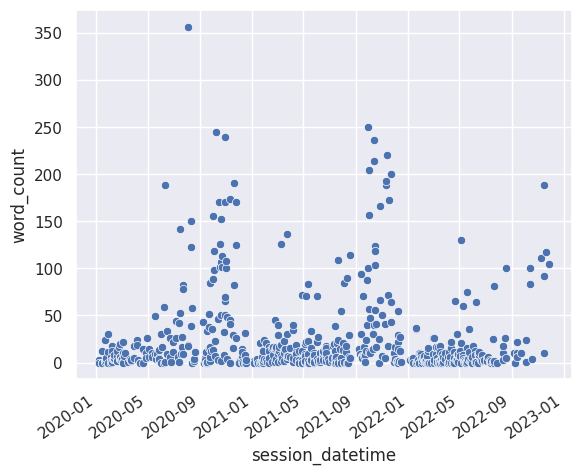

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Select the word we are interested in
budget_counts = meeting_counts[meeting_counts["word_"] == "budget"]

# Plot the responses for different events and regions
sns.scatterplot(
    x="session_datetime",
    y="word_count",
    data=budget_counts,
)
_ = plt.xticks(rotation=35, ha="right")

* again, let's take a step back and talk about what this plot shows
* on the x axis we have the session datetime -- the date when the session took place
* on the y axis we have the word count -- in this case the number of times the word "budget" was used in the meeting at the specified date and time

---

* one thing we can observe is that there is a lot of variation in the number of times the word "budget" is used throughout the year, with "budget" being used more often towards the end of each year
* this is pretty common. most cities have a "budget season" and in seattle's case, "budget season" is in the fall of each year

## Possible Problems?

* while the above plot and counts provide some insight and can demonstrate the cyclic nature of council discussion at a basic level there may be some problems with this basic analysis
* first, meetings have different durations! if a meeting takes more time, more things were discussed in it and therefore more words were used inflating the word counts for that meeting
* second, we are looking at a single word "budget" but should be including it's other variants like "budgeting" and "budgets"

## Possible Solution: Make Each Word Count a "Percentage" of Total Words for The Meeting

* a potential solution for our first problem involving different duration meetings is to convert our plotted value from a simple count to a percent of the total words used in the meeting
* the idea here is that by converting to a percentage we are normalizing the y axis so that all meetings have a value between 0 and 100
* if the y value for a scatter point is 5 that means that 5% of words used in the meeting were the word in question
* in other terms, 5% of words used in the meeting can roughly mean "5 out of every 100 words related to the word in question"

In [13]:
meeting_counts["percent_use_in_meeting"] = (
    # take the current word count
    meeting_counts["word_count"]
    # and divide by the total count of words in it's matching session
    / meeting_counts.groupby("session_id")["word_count"].transform("sum")
)
meeting_counts.sample(5)

,session_id,session_datetime,word_,word_count,percent_use_in_meeting
2280353,b87423b9da9a,2021-02-08 17:30:00+00:00,denser,0,0.000000
3249398,ad93acca5e2b,2021-07-28 16:30:00+00:00,floats,0,0.000000
1196289,a8d6ae13d0fe,2022-04-19 21:00:00+00:00,breach,0,0.000000
3471611,2a8d031f2ad6,2020-10-29 16:30:00+00:00,geography,0,0.000000
1578886,e7f8cb5d5599,2021-03-22 21:00:00+00:00,cleaner,3,0.000725


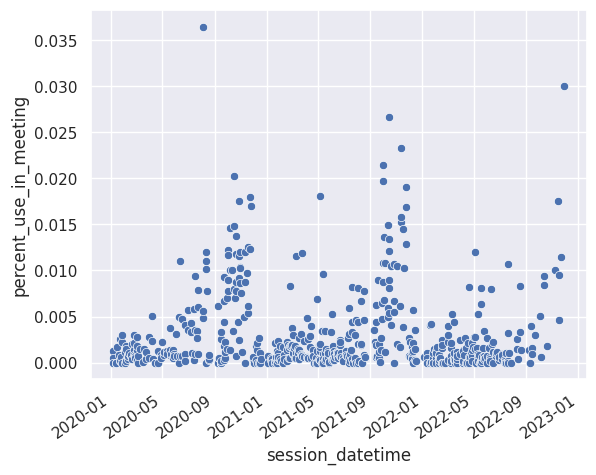

In [14]:
# Select the word we are interested in
budget_counts = meeting_counts[meeting_counts["word_"] == "budget"]

# Plot the responses for different events and regions
sns.scatterplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    data=budget_counts,
)
_ = plt.xticks(rotation=35, ha="right")

* this looks roughly the same as the first plot but we can at least compare across meetings now
* remember that the y-axis now represents a "percent usage of the selected word in this meeting"
* now that the word use is on a shared axis, it also makes it easy to compare across words

---

* for fun, lets compare another word with "budget"
* budgeting is one process handled by council but city councils also commonly pass "resolutions"
* resolutions in Seattle are defined as: Legislation that is administrative or temporary, or which expresses policy. Resolutions are not binding law.
  * https://www.seattle.gov/cityclerk/agendas-and-legislative-resources/legislative-process/legislative-glossary#
* for example, resolutions may be used to name a street after someone, or take a stance on an issue at the federal level that they can't particularly legislate

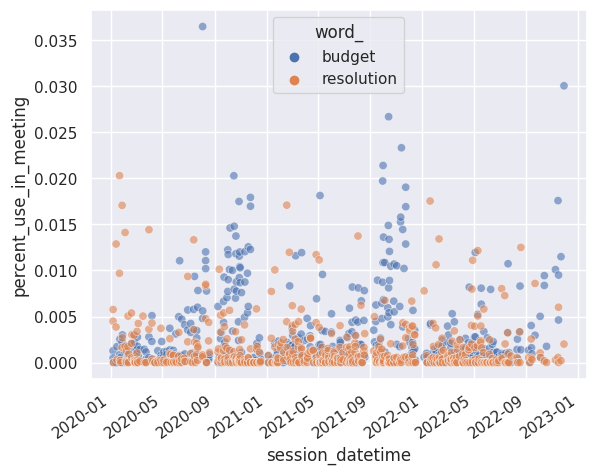

In [15]:
# Select the words we are interested in
target_counts = meeting_counts[meeting_counts["word_"].isin(["budget", "resolution"])]

# Plot the responses for different events and regions
sns.scatterplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    hue="word_",
    alpha=0.6,
    data=target_counts,
)
_ = plt.xticks(rotation=35, ha="right")

* in comparison to discussions on "budget" it seems like discussions on "resolutions" are less frequent and tend towards the earlier part of the year

## Possible Solution: Word Stems

* moving on to the second problem we mentioned, should "we include all the variants of a word in it's count"
* for example should "budget" have a different count from "budgeting" and "budgets"
* in certain cases you want to keep these words separate but in many cases you may want to combine them
* this is done via a process called "stemming" -- finding the "stem" of a word

---

* just like "stop word" filtering is so common that there are tools for it, so is "stemming"

In [16]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

for word in [
    "budgeting",
    "budget",
    "budgets",
    "house",
    "housing",
    "houses",
    "bike",
    "bikes",
    "bicycle",
]:
    stemmed = stemmer.stem(word)
    print(f"Starting word: '{word}', stemmed form: '{stemmed}'")

Starting word: 'budgeting', stemmed form: 'budget'
Starting word: 'budget', stemmed form: 'budget'
Starting word: 'budgets', stemmed form: 'budget'
Starting word: 'house', stemmed form: 'hous'
Starting word: 'housing', stemmed form: 'hous'
Starting word: 'houses', stemmed form: 'hous'
Starting word: 'bike', stemmed form: 'bike'
Starting word: 'bikes', stemmed form: 'bike'
Starting word: 'bicycle', stemmed form: 'bicycl'


* while there are some problems, stemming works really well to get a word down to its "stem"
* "budgeting", "budget", and "budgets" are all stemmed to "budget"
* "house", "housing", and "houses" are all stemmed to "hous"
* "bike" and "bikes" both stem to "bike" but "bicycle" doesn't -- so while this isn't perfect for combining all words to their shared conceptual stem, it does combines a lot of words well

---

* lets add this into the `CountVectorizer` so this stemming process is done for us during counting

In [17]:
# Create custom CountVectorizer with stemming
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        # Get original CountVec analyzer
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()

        # Create stemmer object
        stemmer = SnowballStemmer("english")

        # Stem words prior to counting
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# Initialize this custom count vectorizer
count_vec_with_stemming = StemmedCountVectorizer(
    stop_words="english",
    strip_accents="ascii",
    min_df=0.01,
)

# Process the text and store to new DataFrame
stemmed_meeting_counts = pd.DataFrame(
    count_vec_with_stemming.fit_transform(df.text).toarray(),
    columns=count_vec_with_stemming.get_feature_names_out(),
)

# Add session metadata
stemmed_meeting_counts["session_id"] = df.id
stemmed_meeting_counts["session_datetime"] = df.session_datetime

# Melt
stemmed_meeting_counts = stemmed_meeting_counts.melt(
    id_vars=["session_id", "session_datetime"],
    var_name="word_",
    value_name="word_count",
)

# Calculate percent use in meeting
stemmed_meeting_counts["percent_use_in_meeting"] = (
    # take the current word count
    stemmed_meeting_counts["word_count"]
    # and divide by the total count of words in it's matching session
    / stemmed_meeting_counts.groupby("session_id")["word_count"].transform("sum")
)

stemmed_meeting_counts.sample(5)

,session_id,session_datetime,word_,word_count,percent_use_in_meeting
589147,da5102808a71,2021-04-19 16:30:00+00:00,assur,2,0.000234
4668362,30c932c16ab6,2022-07-12 16:30:00+00:00,surpass,0,0.000000
4824791,a4c0aaaf3c42,2022-03-02 22:00:00+00:00,timer,1,0.000115
5208048,d594eaa5e872,2021-06-21 16:30:00+00:00,weed,0,0.000000
2730693,7b73afd99aed,2020-10-19 21:00:00+00:00,keto,0,0.000000


* before we can plot terms, we need to remember that when selecting the "words" of interest, we need to get their stemmed version first
* for example, if we tried to select data for "house" instead of "hous" (the stemmed form of "house") we wouldn't get any data back

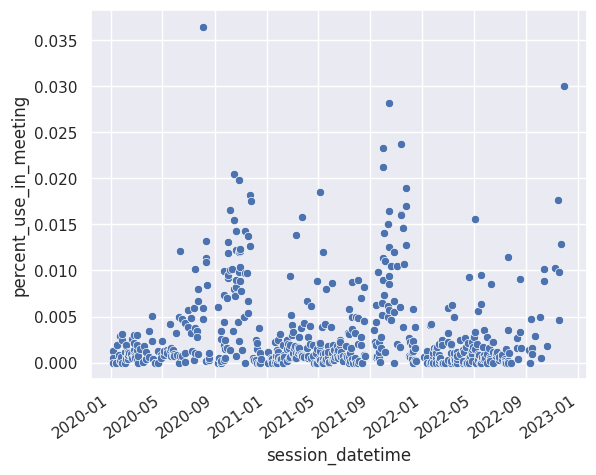

In [18]:
# Select the word we are interested in
budget_counts = stemmed_meeting_counts[
    stemmed_meeting_counts["word_"] == SnowballStemmer("english").stem("budget")
]

# Plot the responses for different events and regions
sns.scatterplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    data=budget_counts,
)
_ = plt.xticks(rotation=35, ha="right")

* lets step back again
* the y-axis now represents the "percent usage of any word that stems to 'budget'" in each meeting

---

* this plot may not look too different for "budget" but lets compare the unstemmed and stemmed plot for "house"

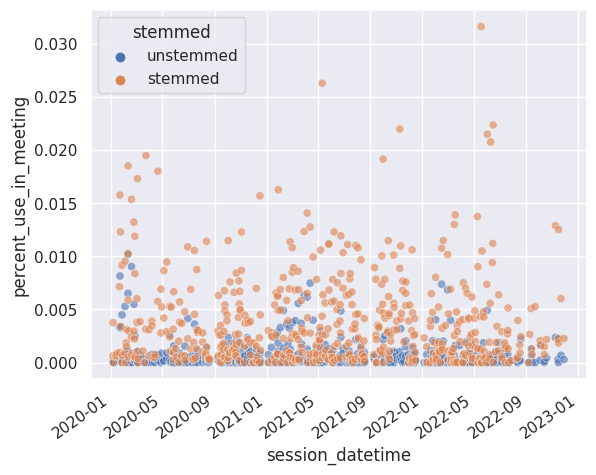

In [19]:
# Select the word we are interested in
unstemmed_house_counts = meeting_counts[
    meeting_counts["word_"] == "house"
].copy()
stemmed_house_counts = stemmed_meeting_counts[
    stemmed_meeting_counts["word_"] == SnowballStemmer("english").stem("house")
].copy()

# Add a variable to track if the word was stemmed or not
unstemmed_house_counts["stemmed"] = "unstemmed"
stemmed_house_counts["stemmed"] = "stemmed"

# Combine the data into a single frame
stemmed_and_unstemmed = pd.concat([unstemmed_house_counts, stemmed_house_counts])

# Plot the responses for different events and regions
sns.scatterplot(
    x="session_datetime",
    y="percent_use_in_meeting",
    hue="stemmed",
    alpha=0.6,
    data=stemmed_and_unstemmed,
)
_ = plt.xticks(rotation=35, ha="right")

* the difference is stark, with stemming, we can see the larger view of discussion involving any of the variants of "house"